# About data set

This database contains 76 attributes, but all published experiments refer to using a subset of 14 of them. In particular, the Cleveland database is the only one that has been used by ML researchers to
this date.The "target" field refers to the presence of heart disease in the patient. It is integer valued 0 = no/less chance of heart attack and 1 = more chance of heart attack

Attribute Information

1) age

2) sex

3) chest pain type (4 values)

4) resting blood pressure

5) serum cholestoral in mg/dl

6) fasting blood sugar > 120 mg/dl

7) resting electrocardiographic results (values 0,1,2)

8) maximum heart rate achieved

9) exercise induced angina

10) oldpeak = ST depression induced by exercise relative to rest

11) the slope of the peak exercise ST segment

12) number of major vessels (0-3) colored by flourosopy

13) thal: 0 = normal; 1 = fixed defect; 2 = reversable defect

14) target: 0= less chance of heart attack 1= more chance of heart attack

Dataset is taken for learning purpose. Source of the data : https://archive.ics.uci.edu/ml/datasets/Heart+Disease

# Import data

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')

In [2]:
#Mount your Google drive so you can read them easily
from google.colab import drive
drive.mount('/content/gdrive')
DataFile = pd.read_csv("/content/gdrive/My Drive/Colab Notebooks/Heart Attack Possibility/heart.csv")
DataFile.head()

Mounted at /content/gdrive


,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
0,63,1,3,145,233,1,0,150,0,2.3,0,0,1,1
1,37,1,2,130,250,0,1,187,0,3.5,0,0,2,1
2,41,0,1,130,204,0,0,172,0,1.4,2,0,2,1
3,56,1,1,120,236,0,1,178,0,0.8,2,0,2,1
4,57,0,0,120,354,0,1,163,1,0.6,2,0,2,1


I will use the 13 columns as features and the last column as the label and seek a model that help predict the label (if a person would probably have a heart attack). Firstly, I leave a small subset of the original data for a test data for final verification.

#Sample a test data

I use stratified sampling to do the splitting so I will have two subsets which have the same ratio of positive labels to negative labels.

In [3]:
from sklearn.model_selection import StratifiedShuffleSplit

split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=123)
for train_index, test_index in split.split(DataFile, DataFile['target']):
    train_set = DataFile.loc[train_index]
    test_set = DataFile.loc[test_index]

print(train_set.shape, test_set.shape)

(242, 14) (61, 14)


#Explore the data

The very first step is to check the data type for each column.

In [4]:
train_set.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 242 entries, 184 to 115
Data columns (total 14 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       242 non-null    int64  
 1   sex       242 non-null    int64  
 2   cp        242 non-null    int64  
 3   trestbps  242 non-null    int64  
 4   chol      242 non-null    int64  
 5   fbs       242 non-null    int64  
 6   restecg   242 non-null    int64  
 7   thalach   242 non-null    int64  
 8   exang     242 non-null    int64  
 9   oldpeak   242 non-null    float64
 10  slope     242 non-null    int64  
 11  ca        242 non-null    int64  
 12  thal      242 non-null    int64  
 13  target    242 non-null    int64  
dtypes: float64(1), int64(13)
memory usage: 28.4 KB


DataFile contains both numerical features and categorical features. Some of the data types are wrong, I'm going to revise them in the next step.

In [5]:
cat_list = ['sex', 'cp', 'fbs', 'restecg', 'exang', 'slope', 'ca', 'thal', 'target']
for fea in cat_list:
  train_set[fea] = train_set[fea].astype("category")

train_set.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 242 entries, 184 to 115
Data columns (total 14 columns):
 #   Column    Non-Null Count  Dtype   
---  ------    --------------  -----   
 0   age       242 non-null    int64   
 1   sex       242 non-null    category
 2   cp        242 non-null    category
 3   trestbps  242 non-null    int64   
 4   chol      242 non-null    int64   
 5   fbs       242 non-null    category
 6   restecg   242 non-null    category
 7   thalach   242 non-null    int64   
 8   exang     242 non-null    category
 9   oldpeak   242 non-null    float64 
 10  slope     242 non-null    category
 11  ca        242 non-null    category
 12  thal      242 non-null    category
 13  target    242 non-null    category
dtypes: category(9), float64(1), int64(4)
memory usage: 14.6 KB


# *Check duplicated instances*

In [7]:
# Any duplicated observations?
train_set[train_set.duplicated().values==True].shape

(0, 14)

No duplicated instances exist in this training set.

# *Check missing values*

In [8]:
# to check any missing values in each feature
obs = train_set.isnull().sum().sort_values(ascending=False)
percent = round(train_set.isnull().sum().sort_values(ascending=False)/len(train_set)*100, 2)
pd.concat([obs, percent], axis=1, keys=['Number of Observations', 'Percent'])

,Number of Observations,Percent
target,0,0.0
thal,0,0.0
ca,0,0.0
slope,0,0.0
oldpeak,0,0.0
exang,0,0.0
thalach,0,0.0
restecg,0,0.0
fbs,0,0.0
chol,0,0.0


Luckily no missing values exist either.

# *Check outliers*

In [9]:
from sklearn.ensemble import IsolationForest
# identify outliers in the dataset
iso = IsolationForest(contamination=0.005)
yhat = iso.fit_predict(train_set)
# select all rows that are not outliers
mask = yhat != -1

In [10]:
# to find the indecies of the the anomalies
outliers_indices = list(item for item in np.where(mask==False)[0])  # must add [0]!

In [11]:
# how many?
len(outliers_indices)

2

In [12]:
print("Outliers Indices: {}\n".format(outliers_indices))

Outliers Indices: [79, 134]



I will remove them later.

#Visualize the data

In [ ]:
train_set.describe()

,age,trestbps,chol,thalach,oldpeak
count,242.000000,242.000000,242.000000,242.000000,242.000000
mean,54.619835,131.764463,245.090909,149.066116,1.039256
std,8.840924,17.457901,52.484655,22.680255,1.171723
min,29.000000,94.000000,126.000000,71.000000,0.000000
25%,48.000000,120.000000,208.250000,132.000000,0.000000
50%,55.500000,130.000000,239.000000,152.500000,0.750000
75%,61.000000,140.000000,273.000000,165.000000,1.600000
max,76.000000,200.000000,564.000000,202.000000,6.200000


# *Plot histograms and scatter plots*

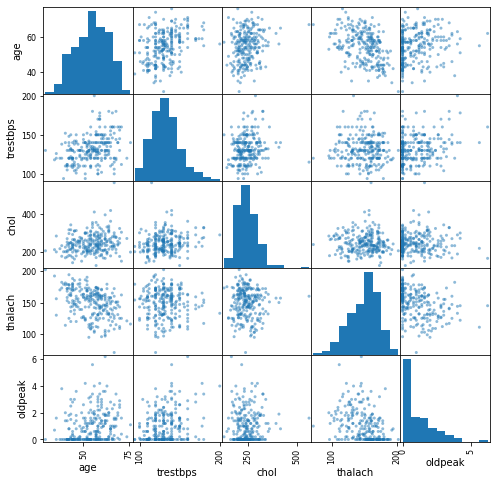

In [ ]:
from pandas.plotting import scatter_matrix

numeric_list = ['age','trestbps','chol','thalach','oldpeak']

# histograms and scatter plots.
scatter_matrix(train_set[numeric_list], figsize=(8,8))
plt.show()

It seems that age has a relationship with thalach and oldpeak respectively.

The 5 features are not normally distributed. I will do standard scaler transformation for them later.

# *Any numerical features pairwise correlated?*

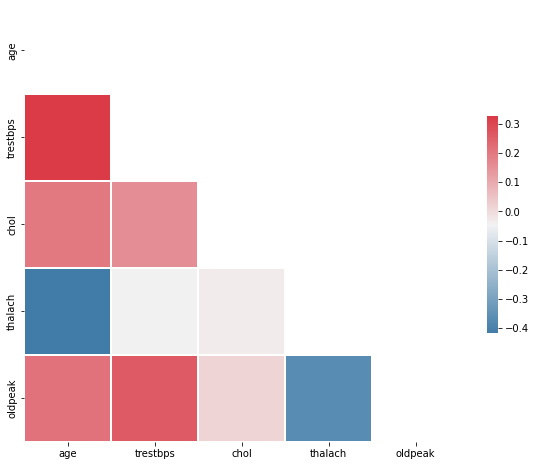

In [ ]:
import seaborn as sns

#sns.set_theme(style="white")
numeric_list = ['age','trestbps','chol','thalach','oldpeak']
# to compute the correlation matrix
corr = (train_set[numeric_list]).corr()

# to generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=bool))

# to set up the matplotlib figure
f, ax = plt.subplots(figsize=(10, 8))

# to generate a custom diverging colormap
cmap = sns.diverging_palette(240, 10, as_cmap=True)

# to draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, square=True, linewidths=.5, cbar_kws={"shrink": .5})

The heatmap shows the numerical features are not strongly correlated pairwise! Next I check if more than 3 (inclusive) of the numerical features are correlated.

# *Check Multi-Collinearity*

In [ ]:
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant
from statsmodels.regression.linear_model import OLS

def variance_inflation_factors(exog_df):
    '''
    Parameters
    ----------
    exog_df : dataframe, (nobs, k_vars)
        design matrix with all explanatory variables, as for example used in
        regression.

    Returns
    -------
    vif : Series
        variance inflation factors
    '''
    exog_df = add_constant(exog_df)
    vifs = pd.Series(
        [1 / (1. - OLS(exog_df[col].values, 
                       exog_df.loc[:, exog_df.columns != col].values).fit().rsquared) 
         for col in exog_df],
        index=exog_df.columns,
        name='VIF'
    )
    return vifs

In [ ]:
# to calculate VIF
variance_inflation_factors(train_set[numeric_list])

const       173.549750
age           1.408356
trestbps      1.224060
chol          1.056703
thalach       1.391205
oldpeak       1.243849
Name: VIF, dtype: float64

Good! The VIF table shows no multi-correlation exists.

# *Any categorical features independent from one another?*

In [ ]:
from scipy.stats import chi2_contingency

# to define a function that calculate p-value from Chi Square test for a pair of categorical variables
def chisq_of_df_cols(df, col1, col2):
  chi2, p, dof, expected = chi2_contingency(pd.crosstab(df[col1], df[col2]))
  return(p)

# to build a matrix whose cells store p-values
def ChiSqMatrix(df, L):
  Len = len(L)
  Size = Len*Len
  arr = np.zeros(Size).reshape((Len,Len))
  for i in np.arange(Len):
    for j in np.arange(Len):
      #arr[i,j] = np.round(chisq_of_df_cols(df, L[i], L[j]), 10)
      arr[i,j] = chisq_of_df_cols(df, L[i], L[j])
  return arr

cat_list = ['sex', 'cp', 'fbs', 'restecg', 'exang', 'slope', 'ca', 'thal'] # exclude 'target'
independenceMatrix = pd.DataFrame(ChiSqMatrix(train_set, cat_list), columns=cat_list)
independenceMatrix.index = cat_list
independenceMatrix

,sex,cp,fbs,restecg,exang,slope,ca,thal
sex,1.441865e-53,2.201554e-01,8.028179e-01,3.187797e-02,3.614615e-02,6.041899e-01,4.065581e-01,4.282185e-08
cp,2.201554e-01,1.775530e-150,2.635195e-01,1.676193e-01,2.162924e-12,5.683182e-03,7.989541e-03,1.786217e-05
fbs,8.028179e-01,2.635195e-01,8.063086e-53,6.111162e-01,3.666971e-01,3.869998e-02,5.140144e-01,2.013443e-01
restecg,3.187797e-02,1.676193e-01,6.111162e-01,1.933489e-103,1.419930e-01,2.991004e-02,5.961838e-01,9.257460e-01
exang,3.614615e-02,2.162924e-12,3.666971e-01,1.419930e-01,1.307327e-53,2.747795e-05,1.188730e-01,4.092060e-07
slope,6.041899e-01,5.683182e-03,3.869998e-02,2.991004e-02,2.747795e-05,1.933489e-103,1.411415e-01,1.194610e-04
ca,4.065581e-01,7.989541e-03,5.140144e-01,5.961838e-01,1.188730e-01,1.411415e-01,7.929968e-196,1.329874e-01
thal,4.282185e-08,1.786217e-05,2.013443e-01,9.257460e-01,4.092060e-07,1.194610e-04,1.329874e-01,1.775530e-150


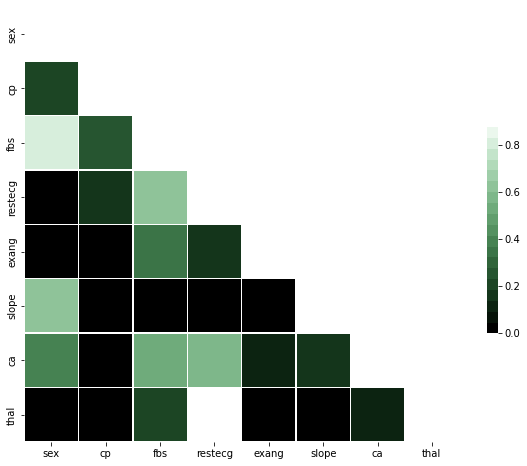

In [ ]:
# to generate a mask for the upper triangle
mask = np.triu(np.ones_like(independenceMatrix, dtype=bool))

# to set up the matplotlib figure
f, ax = plt.subplots(figsize=(10, 8))

# to generate a custom diverging colormap
cmap = sns.cubehelix_palette(20, start=2, rot=0, dark=0, light=1, reverse=True)

# to draw the heatmap with the mask and correct aspect ratio
sns.heatmap(independenceMatrix, mask=mask, cmap=cmap, square=True, linewidths=.5, cbar_kws={"shrink": .5})

The significant level is 0.05, the 12 dark squares in the above heatmap indicate 12 pairs of categorical features are not independent from each other. However, they don't possess the nature of numeric features, thus I cannot combine them pairwise or drop any of them. Consequently, I keep them in the training data.

#Prepare the data

# *Data cleaning* 

# *Remove outliers*

There are some outliers in the data, so I need to remove them.

In [ ]:
# to exclude the outliers
train_Outl_Excl = train_set.copy()

train_Outl_Excl = train_Outl_Excl.drop(outliers_indices)
train_Outl_Excl.shape

(240, 14)

train_Outl_Excl is the training data that doesn't contain any outliers!

# *Split training data into two parts: a smaller training data and a validation data*

In [ ]:
train_Outl_Excl.head()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
184,50,1,0,150,243,0,0,128,0,2.6,1,0,3,0
100,42,1,3,148,244,0,0,178,0,0.8,2,2,2,1
43,53,0,0,130,264,0,0,143,0,0.4,1,0,2,1
128,52,0,2,136,196,0,0,169,0,0.1,1,0,2,1
249,69,1,2,140,254,0,0,146,0,2.0,1,3,3,0


I need a validation data for hyperparameter tuning.

In [ ]:
split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=123)
for train_index, val_index in split.split(train_Outl_Excl, train_Outl_Excl['target']):
  strat_train_set = train_Outl_Excl.iloc[train_index]
  strat_val_set = train_Outl_Excl.iloc[val_index]

print(strat_train_set.shape) 
print(strat_val_set.shape)

(192, 14)
(48, 14)


In [ ]:
features = strat_train_set.drop("target", axis=1)
label = strat_train_set["target"].copy()
print(features.shape, label.shape)

(192, 13) (192,)


# *Feature engineering and feature scaling*

In [ ]:
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder


num_attr =['age', 'trestbps', 'chol', 'thalach', 'oldpeak']
cat_attr = ['sex', 'cp', 'fbs', 'restecg', 'exang', 'slope', 'ca', 'thal']

full_pipeline = ColumnTransformer([
                                   ('num', StandardScaler(), num_attr),
                                   ('cat', OneHotEncoder(), cat_attr),
])

training_prepared = full_pipeline.fit_transform(features)

# *Feature Names Extraction*

In [ ]:
from sklearn.preprocessing import OneHotEncoder

encoder = OneHotEncoder()
train_X_encoded = encoder.fit_transform(features[cat_attr])  

In [ ]:
# the new feature names 
encoder.get_feature_names()

array(['x0_0', 'x0_1', 'x1_0', 'x1_1', 'x1_2', 'x1_3', 'x2_0', 'x2_1',
       'x3_0', 'x3_1', 'x3_2', 'x4_0', 'x4_1', 'x5_0', 'x5_1', 'x5_2',
       'x6_0', 'x6_1', 'x6_2', 'x6_3', 'x6_4', 'x7_0', 'x7_1', 'x7_2',
       'x7_3'], dtype=object)

New names are given. Must map them back to their original names when checking feature importance.

In [ ]:
len(encoder.get_feature_names())

25

# *Feature Importance Function*

In [ ]:
# to print the feature importance list of the best estimator
from sklearn.inspection import permutation_importance

def print_features_importance(model_name, best_estimator, X, y):
  feature_names = num_attr + list(encoder.get_feature_names())  
    
  importance=[]
  best_estimator.fit(X, y)
  # perform permutation importance
  results = permutation_importance(best_estimator, X, y, scoring='f1_micro')   # scoring='roc_auc'
  # get importance
  importance = results.importances_mean
    
  for i,v in tqdm(enumerate(importance)):
    if v > 0.0005:   # this threshold can be adjusted!
      print('Feature: %-12s, Score: %.5f' % (feature_names[i],v))
    
  # plot feature importance
  plt.figure(figsize=(24, 6))
  plt.bar([x for x in range(len(importance))], importance)
  # Add some text for labels, title and custom x-axis tick labels, etc.
  width = 0.5  # the width of the bars
  plt.ylabel('Feature Importance')
  plt.title(model_name)
  plt.xticks(ticks=np.arange(len(feature_names)),labels=feature_names,rotation=90)
  plt.show()

I would like to try three methodologies: logistic regression, random forest, and support vector machine.

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC

from sklearn.metrics import f1_score
from sklearn.model_selection import cross_val_score

from tqdm import tqdm, tqdm_gui

# *Important features*

30it [00:00, 59465.56it/s]


Feature: age         , Score: 0.00417
Feature: trestbps    , Score: 0.01250
Feature: chol        , Score: 0.00625
Feature: thalach     , Score: 0.02396
Feature: oldpeak     , Score: 0.02604
Feature: x0_0        , Score: 0.00833
Feature: x0_1        , Score: 0.00937
Feature: x1_0        , Score: 0.03021
Feature: x1_1        , Score: 0.00104
Feature: x4_0        , Score: 0.00313
Feature: x5_1        , Score: 0.00208
Feature: x5_2        , Score: 0.00208
Feature: x6_0        , Score: 0.00833
Feature: x7_2        , Score: 0.01667
Feature: x7_3        , Score: 0.00104


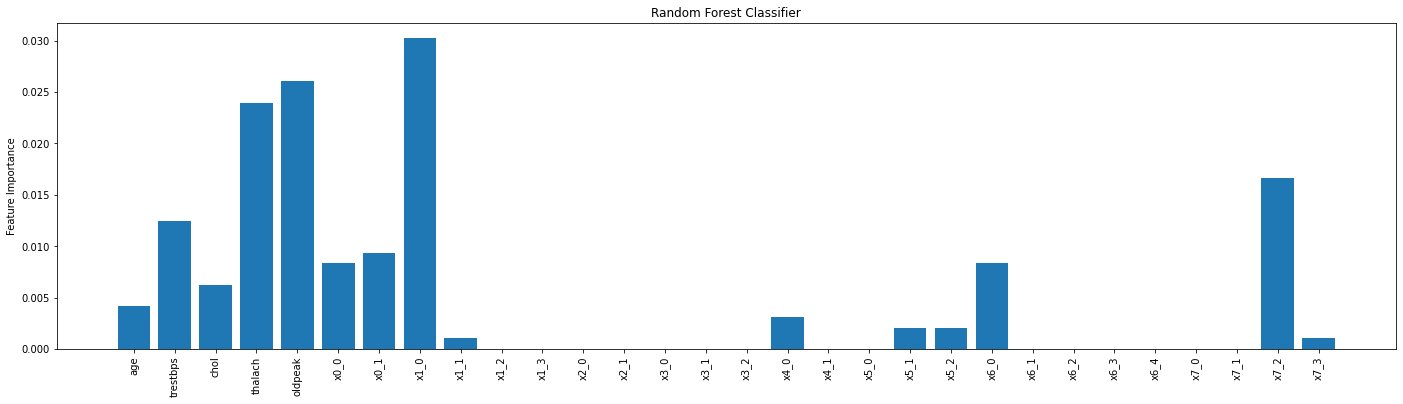

In [ ]:
# to calculate feature importance
print_features_importance('Random Forest Classifier', RandomForestClassifier(random_state=42), training_prepared, label)

Two features are unimportant, I will remove them and reconstruct the training data.

# *Remove the two features -- 'fbs' and 'restecg' after feature engineering step*

In [ ]:
# New pipeline with shorter list of features!
num_attr =['age','trestbps','chol','thalach','oldpeak']
cat_attr = ['sex', 'cp', 'exang', 'slope', 'ca', 'thal']

full_pipeline = ColumnTransformer([
                                   ('num', StandardScaler(), num_attr),
                                   ('cat', OneHotEncoder(), cat_attr),
])

# *New training data*

In [ ]:
training_prepared = full_pipeline.fit_transform(features)

In [ ]:
training_prepared.shape

(192, 25)

# *Validation data transformation*

In [ ]:
strat_val_set.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 48 entries, 30 to 39
Data columns (total 14 columns):
 #   Column    Non-Null Count  Dtype   
---  ------    --------------  -----   
 0   age       48 non-null     int64   
 1   sex       48 non-null     category
 2   cp        48 non-null     category
 3   trestbps  48 non-null     int64   
 4   chol      48 non-null     int64   
 5   fbs       48 non-null     category
 6   restecg   48 non-null     category
 7   thalach   48 non-null     int64   
 8   exang     48 non-null     category
 9   oldpeak   48 non-null     float64 
 10  slope     48 non-null     category
 11  ca        48 non-null     category
 12  thal      48 non-null     category
 13  target    48 non-null     category
dtypes: category(9), float64(1), int64(4)
memory usage: 3.8 KB


In [ ]:
features_val = strat_val_set.drop("target", axis=1)
label_val = strat_val_set["target"].copy()
print(features_val.shape, label_val.shape)

(48, 13) (48,)


In [ ]:
X_val = full_pipeline.transform(features_val)
X_val.shape

(48, 25)

# *Baseline of chosen models*

In [ ]:
# list of models to be tested
models = [
        ('RandomForestClassifier',  RandomForestClassifier(random_state=42)),
        ('LogisticReg', LogisticRegression(random_state=42)),
        ('SVM', SVC(random_state=42)),
]

In [ ]:
label.value_counts()

1    104
0     88
Name: target, dtype: int64

Since the label is not balanced, I don't use accuracy as the metric to assess the performance of the methodologies, instead, I use F1 score as the metric to do it.

In [ ]:
%%time
from tqdm import tqdm, tqdm_gui
## to evaluate the models using cross validation
model_names=[]
model_scores=[]
model_scores_mean=[]
model_scores_std=[]
cv=4

for name, model in tqdm(models):
    model_score = cross_val_score(model, training_prepared, label, scoring='f1_micro', cv=cv)
   
    model_names.append(name)
    model_scores.append(model_score)
    model_scores_mean.append(model_score.mean())
    model_scores_std.append(model_score.std())

100%|██████████| 3/3 [00:00<00:00,  4.22it/s]

CPU times: user 696 ms, sys: 2.72 ms, total: 699 ms
Wall time: 716 ms


In [ ]:
model_cv_results = pd.DataFrame({
    'Model':model_names, 
    'F1 Score': [np.round(x, 4) for x in model_scores], 
    'Mean of F1 Score': model_scores_mean,
    'Std of F1 Score': model_scores_std
    })
model_cv_results.sort_values(by='Mean of F1 Score', ascending=False, ignore_index=True)

,Model,F1 Score,Mean of F1 Score,Std of F1 Score
0,LogisticReg,"[0.875, 0.8542, 0.8958, 0.7917]",0.854167,0.038976
1,RandomForestClassifier,"[0.7917, 0.8542, 0.8542, 0.8125]",0.828125,0.027063
2,SVM,"[0.7917, 0.8125, 0.8125, 0.7917]",0.802083,0.010417


It seems logistic regression dominates in these classifications. Next, I will fine tune logistic regression.

# *Fine tune logitstic regression -- Bayesian Optimization (Method1: BayesSearchCV in skopt)*

In [ ]:
pip install scikit-optimize

     |████████████████████████████████| 100 kB 5.2 MB/s 


In [ ]:
from skopt import BayesSearchCV
from skopt.space import Real, Categorical, Integer
from skopt.plots import plot_objective, plot_histogram

# *Learning Curve Function*

In [ ]:
# to create a learning curve
# M is the number of instances used in one batch
def plot_learning_curve(model, X_train, y_train, X_val, y_val, M):
    train_errors, val_errors = [], []
    for m in tqdm(range(3, len(X_train), M)):  # change the lower bound when necessary
        model.fit(X_train[:m], y_train[:m])
        y_train_predict = model.predict(X_train[:m])
        y_val_predict = model.predict(X_val)
        train_errors.append(f1_score(y_train[:m], y_train_predict, average='micro'))
        val_errors.append(f1_score(y_val, y_val_predict, average='micro'))
    plt.figure(figsize=(12,8))
    plt.ylim([0.1, 1.1]) # Must adjust the range! 
    plt.title('F1 Score')
    plt.yticks(np.arange(0.1, 1.1, 0.05))
    plt.grid(color = 'green', linestyle = '--', linewidth = 0.5)
    plt.plot(train_errors, "r-+", linewidth=2, label='train')
    plt.plot(val_errors, "b-", linewidth=3, label='val')
    plt.legend() # in case labels don't show up
    plt.show() 

I construct tuning space of 3 hyperparameters according to the documentation of sklearn.

# *1st tuning*

In [ ]:
import time
start = time.time()

np.random.seed(42)

# pipeline class is used as estimator to enable
# search over different model types
pipe = Pipeline([
    ('model', LogisticRegression())
])

# explicit dimension classes can be specified like this
logit_search = {
    'model': Categorical([LogisticRegression(random_state=42)]),
    'model__C': Real(1e-4, 1e+4, prior='log-uniform'),
    'model__penalty': Categorical(['l2', 'none']),
    'model__solver': Categorical(['lbfgs', 'newton-cg'])
}

opt = BayesSearchCV(
    pipe,
    # (parameter space, # of evaluations)
    [(logit_search, 10)],
    cv=4,
    verbose=2
)

opt.fit(training_prepared, label)

end = time.time()
timeElapse = end - start
print("It takes %s minutes"%round((timeElapse/60), 2))

Fitting 4 folds for each of 1 candidates, totalling 4 fits
[CV] END model=LogisticRegression(random_state=42), model__C=66.3446558203086, model__penalty=none, model__solver=lbfgs; total time=   0.0s
[CV] END model=LogisticRegression(random_state=42), model__C=66.3446558203086, model__penalty=none, model__solver=lbfgs; total time=   0.0s
[CV] END model=LogisticRegression(random_state=42), model__C=66.3446558203086, model__penalty=none, model__solver=lbfgs; total time=   0.0s
[CV] END model=LogisticRegression(random_state=42), model__C=66.3446558203086, model__penalty=none, model__solver=lbfgs; total time=   0.0s
Fitting 4 folds for each of 1 candidates, totalling 4 fits
[CV] END model=LogisticRegression(random_state=42), model__C=1165.5266791092008, model__penalty=l2, model__solver=newton-cg; total time=   0.0s
[CV] END model=LogisticRegression(random_state=42), model__C=1165.5266791092008, model__penalty=l2, model__solver=newton-cg; total time=   0.0s
[CV] END model=LogisticRegression(

In [ ]:
opt.best_params_

OrderedDict([('model',
              LogisticRegression(C=1165.5266791092008, random_state=42, solver='newton-cg')),
             ('model__C', 1165.5266791092008),
             ('model__penalty', 'l2'),
             ('model__solver', 'newton-cg')])

In [ ]:
opt.best_score_

0.8281249999999999

This is lower than 0.85 -- the baseline. I will check the metric from the validation data.

In [ ]:
opt.score(X_val, label_val)

0.8333333333333334

100%|██████████| 19/19 [00:00<00:00, 66.48it/s]


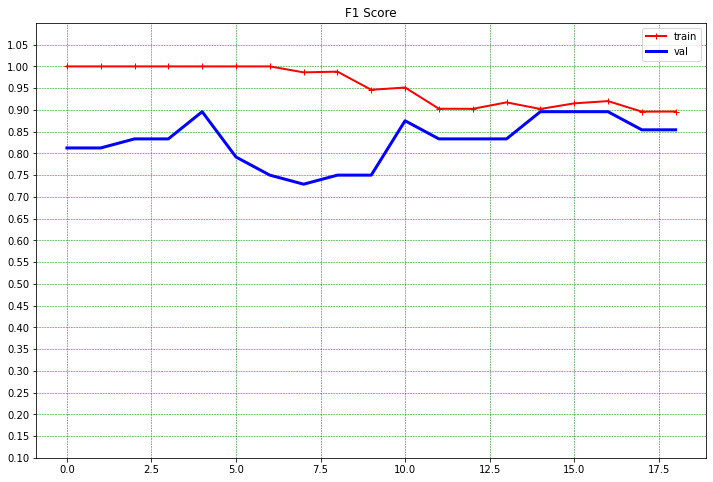

CPU times: user 536 ms, sys: 28.3 ms, total: 565 ms
Wall time: 550 ms


In [ ]:
%%time

my_model = LogisticRegression(
    C = int(opt.best_params_['model__C']),
    penalty = opt.best_params_['model__penalty'],
    solver = opt.best_params_['model__solver']
)

plot_learning_curve(my_model, training_prepared, label, X_val, label_val, M=10)

It is a good signal that validation curve approachs train curve as data batches increase.

# *2nd tuning*

I revise the tuning space a bit.

In [ ]:
start = time.time()

np.random.seed(42)

# pipeline class is used as estimator to enable
# search over different model types
pipe = Pipeline([
    ('model', LogisticRegression())
])

# explicit dimension classes can be specified like this
logit_search = {
    'model': Categorical([LogisticRegression(random_state=42)]),
    'model__C': Real(1e-3, 1e+3, prior='log-uniform'),
    'model__penalty': Categorical(['l2', 'none']),
    'model__solver': Categorical(['lbfgs', 'newton-cg'])
}

opt = BayesSearchCV(
    pipe,
    # (parameter space, # of evaluations)
    [(logit_search, 10)],
    cv=4,
    verbose=2
)

opt.fit(training_prepared, label)

end = time.time()
timeElapse = end - start
print("It takes %s minutes"%round((timeElapse/60), 2))

Fitting 4 folds for each of 1 candidates, totalling 4 fits
[CV] END model=LogisticRegression(random_state=42), model__C=23.24633323298668, model__penalty=none, model__solver=lbfgs; total time=   0.0s
[CV] END model=LogisticRegression(random_state=42), model__C=23.24633323298668, model__penalty=none, model__solver=lbfgs; total time=   0.0s
[CV] END model=LogisticRegression(random_state=42), model__C=23.24633323298668, model__penalty=none, model__solver=lbfgs; total time=   0.0s
[CV] END model=LogisticRegression(random_state=42), model__C=23.24633323298668, model__penalty=none, model__solver=lbfgs; total time=   0.0s
Fitting 4 folds for each of 1 candidates, totalling 4 fits
[CV] END model=LogisticRegression(random_state=42), model__C=199.47646544646798, model__penalty=l2, model__solver=newton-cg; total time=   0.0s
[CV] END model=LogisticRegression(random_state=42), model__C=199.47646544646798, model__penalty=l2, model__solver=newton-cg; total time=   0.0s
[CV] END model=LogisticRegress

In [ ]:
opt.best_params_

OrderedDict([('model',
              LogisticRegression(C=199.47646544646798, random_state=42, solver='newton-cg')),
             ('model__C', 199.47646544646798),
             ('model__penalty', 'l2'),
             ('model__solver', 'newton-cg')])

In [ ]:
opt.best_score_

0.8281249999999999

In [ ]:
opt.score(X_val, label_val)

0.8541666666666666

This score from the validation data is better than that of the 1st tuning.

100%|██████████| 19/19 [00:00<00:00, 70.56it/s]


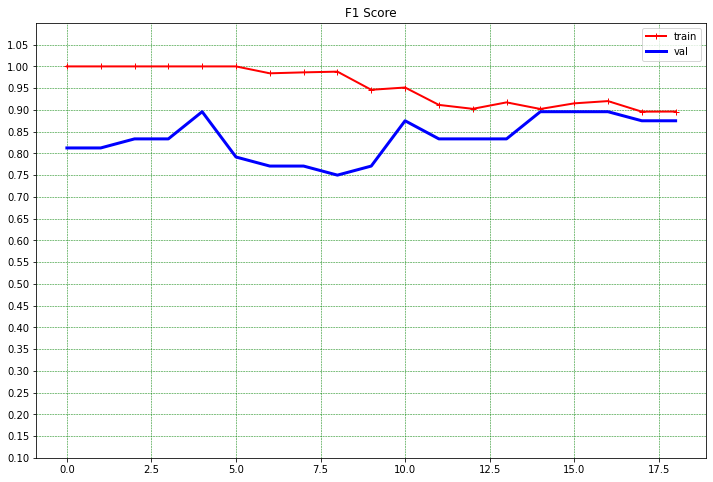

CPU times: user 509 ms, sys: 29.8 ms, total: 539 ms
Wall time: 534 ms


In [ ]:
%%time

my_model = LogisticRegression(
    C = int(opt.best_params_['model__C']),
    penalty = opt.best_params_['model__penalty'],
    solver = opt.best_params_['model__solver']
)

plot_learning_curve(my_model, training_prepared, label, X_val, label_val, M=10)

The val curve approaches 0.875 in the end of the process in the 2nd tuning, a bit higher than what it approach in the 1st tuning.

In [ ]:
start = time.time()

np.random.seed(42)

# pipeline class is used as estimator to enable
# search over different model types
pipe = Pipeline([
    ('model', LogisticRegression())
])

# explicit dimension classes can be specified like this
logit_search = {
    'model': Categorical([LogisticRegression(random_state=42)]),
    'model__C': Real(1e-2, 1e+2, prior='log-uniform'),
    'model__penalty': Categorical(['l2', 'none']),
    'model__solver': Categorical(['lbfgs', 'newton-cg'])
}

opt = BayesSearchCV(
    pipe,
    # (parameter space, # of evaluations)
    [(logit_search, 10)],
    cv=4,
    verbose=2
)

opt.fit(training_prepared, label)

end = time.time()
timeElapse = end - start
print("It takes %s minutes"%round((timeElapse/60), 2))

Fitting 4 folds for each of 1 candidates, totalling 4 fits
[CV] END model=LogisticRegression(random_state=42), model__C=8.145222883402798, model__penalty=none, model__solver=lbfgs; total time=   0.0s
[CV] END model=LogisticRegression(random_state=42), model__C=8.145222883402798, model__penalty=none, model__solver=lbfgs; total time=   0.0s
[CV] END model=LogisticRegression(random_state=42), model__C=8.145222883402798, model__penalty=none, model__solver=lbfgs; total time=   0.0s
[CV] END model=LogisticRegression(random_state=42), model__C=8.145222883402798, model__penalty=none, model__solver=lbfgs; total time=   0.0s
Fitting 4 folds for each of 1 candidates, totalling 4 fits
[CV] END model=LogisticRegression(random_state=42), model__C=34.139810765573976, model__penalty=l2, model__solver=newton-cg; total time=   0.0s
[CV] END model=LogisticRegression(random_state=42), model__C=34.139810765573976, model__penalty=l2, model__solver=newton-cg; total time=   0.0s
[CV] END model=LogisticRegress

In [ ]:
opt.best_params_

OrderedDict([('model',
              LogisticRegression(C=12.631575298699973, random_state=42, solver='newton-cg')),
             ('model__C', 12.631575298699973),
             ('model__penalty', 'l2'),
             ('model__solver', 'newton-cg')])

In [ ]:
opt.best_score_

0.8385416666666666

In [ ]:
opt.score(X_val, label_val)

0.8541666666666666

100%|██████████| 19/19 [00:00<00:00, 77.14it/s]


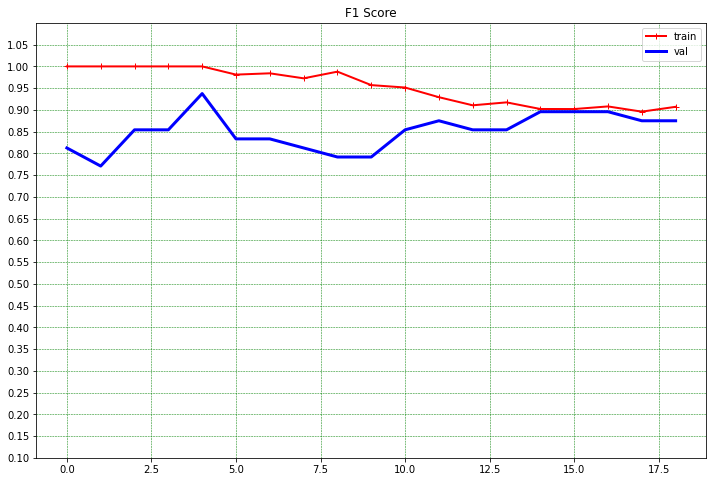

CPU times: user 501 ms, sys: 6.15 ms, total: 507 ms
Wall time: 508 ms


In [ ]:
%%time

my_model = LogisticRegression(
    C = int(opt.best_params_['model__C']),
    penalty = opt.best_params_['model__penalty'],
    solver = opt.best_params_['model__solver']
)

plot_learning_curve(my_model, training_prepared, label, X_val, label_val, M=10)

The 3rd one is not much different from the 2nd one.

# *Save the tuned model for prediction*

The model from the 3rd tuning is my final model. I will save it.

In [ ]:
import joblib
#to save the best logistic regression
joblib.dump(my_model, "/content/gdrive/My Drive/Colab Notebooks/Heart Attack Possibility/bestLogit_Nov30.pkl")

['/content/gdrive/My Drive/Colab Notebooks/Heart Attack Possibility/bestLogit_Nov30.pkl']

# Measure the performance of the final model on the test data

Now, it is time to transform the test data and use it to make prediction.

# *Transform Test Data*

In [ ]:
cat_list = ['sex', 'cp', 'fbs', 'restecg', 'exang', 'slope', 'ca', 'thal', 'target']
for fea in cat_list:
  test_set[fea] = test_set[fea].astype("category")

test_set.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 61 entries, 233 to 288
Data columns (total 14 columns):
 #   Column    Non-Null Count  Dtype   
---  ------    --------------  -----   
 0   age       61 non-null     int64   
 1   sex       61 non-null     category
 2   cp        61 non-null     category
 3   trestbps  61 non-null     int64   
 4   chol      61 non-null     int64   
 5   fbs       61 non-null     category
 6   restecg   61 non-null     category
 7   thalach   61 non-null     int64   
 8   exang     61 non-null     category
 9   oldpeak   61 non-null     float64 
 10  slope     61 non-null     category
 11  ca        61 non-null     category
 12  thal      61 non-null     category
 13  target    61 non-null     category
dtypes: category(9), float64(1), int64(4)
memory usage: 4.5 KB


In [ ]:
test_set.head()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
233,64,1,0,120,246,0,0,96,1,2.2,0,1,2,0
243,57,1,0,152,274,0,1,88,1,1.2,1,1,3,0
121,59,1,0,138,271,0,0,182,0,0.0,2,0,2,1
163,38,1,2,138,175,0,1,173,0,0.0,2,4,2,1
238,77,1,0,125,304,0,0,162,1,0.0,2,3,2,0


In [ ]:
test_noIndex = test_set.copy()
test_noIndex = test_noIndex.reset_index()
test_noIndex.head()

,index,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
0,233,64,1,0,120,246,0,0,96,1,2.2,0,1,2,0
1,243,57,1,0,152,274,0,1,88,1,1.2,1,1,3,0
2,121,59,1,0,138,271,0,0,182,0,0.0,2,0,2,1
3,163,38,1,2,138,175,0,1,173,0,0.0,2,4,2,1
4,238,77,1,0,125,304,0,0,162,1,0.0,2,3,2,0


In [ ]:
features_test = test_set.drop("target", axis=1)

print(features_test.shape)

(61, 13)


In [ ]:
X_test = full_pipeline.transform(features_test)
X_test.shape

(61, 25)

In [ ]:
# to load this model later
import joblib
my_model_loaded = joblib.load("/content/gdrive/My Drive/Colab Notebooks/Heart Attack Possibility/bestLogit_Nov30.pkl")

In [ ]:
# to predict the target value for the test data using the chosen model
test_prediction = my_model_loaded.predict(X_test)

In [ ]:
len(test_prediction)

61

In [ ]:
# to attach the predicted target to the original test data
test_prediction = pd.DataFrame(test_prediction)
test_prediction.columns = ['predicted_target']
final_test_prediction = pd.concat([test_noIndex, test_prediction], axis=1)
final_test_prediction.head()

,index,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target,predicted_target
0,233,64,1,0,120,246,0,0,96,1,2.2,0,1,2,0,0
1,243,57,1,0,152,274,0,1,88,1,1.2,1,1,3,0,0
2,121,59,1,0,138,271,0,0,182,0,0.0,2,0,2,1,1
3,163,38,1,2,138,175,0,1,173,0,0.0,2,4,2,1,1
4,238,77,1,0,125,304,0,0,162,1,0.0,2,3,2,0,1


In [ ]:
final_test_prediction.set_index('index')

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target,predicted_target
index,,,,,,,,,,,,,,,
233,64,1,0,120,246,0,0,96,1,2.2,0,1,2,0,0
243,57,1,0,152,274,0,1,88,1,1.2,1,1,3,0,0
121,59,1,0,138,271,0,0,182,0,0.0,2,0,2,1,1
163,38,1,2,138,175,0,1,173,0,0.0,2,4,2,1,1
238,77,1,0,125,304,0,0,162,1,0.0,2,3,2,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
297,59,1,0,164,176,1,0,90,0,1.0,1,2,1,0,0
116,41,1,2,130,214,0,0,168,0,2.0,1,0,2,1,1
271,61,1,3,134,234,0,1,145,0,2.6,1,2,2,0,1


In [ ]:
from sklearn.metrics import f1_score
f1_score(final_test_prediction['target'], final_test_prediction['predicted_target'])

0.8450704225352113

# Conclusion

This report shows that how to preprocess the data including picking appropriate features and how to make use of features to make prediction for any unseen data. The key part here is to choose a promissing model that can give the best prediction. In order to do it, I employ Bayesian Optimization to do hyperparameter tuning. During the process, I define the hyperparameters' range by trial-and-error. Finally, the testing result from the test data verifies the chosen model works well and the prediction is quite reliable. If more time is permitted, I will increase the number of evaluations in Bayesian Optimization part and improve F1 score. In conclustion, the report showcases the rountine process of classification clearly and precisely.